Importing Libraries

In [11]:
import requests
from bs4 import BeautifulSoup
import os
from selenium import webdriver
from selenium.webdriver.common.by import By
import time
from datetime import datetime
import pandas as pd
from selenium.webdriver.chrome.options import Options
from concurrent.futures import ThreadPoolExecutor
from skimage.feature import local_binary_pattern
import cv2
import numpy as np


In [13]:
url_dict ={
    "bellanaija": ["https://www.bellanaija.com/2025/11/lagos-fashion-week-2025-see-emmy-kasbits-collection/"]
    }

In [14]:
driver = webdriver.Chrome()

for web_page, urls in url_dict.items():
    folder = os.path.join('kasbit_images', web_page)
    if os.path.exists(folder):
        continue
    os.makedirs(folder, exist_ok=True)

    for url in urls:
        driver.get(url)
        time.sleep(15)

        elements = driver.find_elements(By.TAG_NAME, 'img')
        print(f"Found {len(elements)} image elements.")

        count = 0
        for index, img in enumerate(elements):
            src = img.get_attribute('src')
            if src and src.startswith("http"):
                try:
                    img_data = requests.get(src).content
                    filename = f"{'kasbit'}_{web_page}_{index+1}.jpg"
                    path = os.path.join(folder, filename)
                    with open((path), 'wb') as f:
                        f.write(img_data)
                except Exception as e:
                    print(f"Error downloading image {src}: {e}")
                    continue
        

driver.quit()
print("All Images from all websites downloaded.")

Found 75 image elements.
All Images from all websites downloaded.


VGG16 MODEL - COLOUR EXTRACTION(DONE), SIHLOUETTE EXTRACTION, FABRIC EXTRACTION

PREPROCESSING - VGG16

In [16]:
dataset_dict = {"kasbit_images": ["bellanaija"]}

processed_pics = {}

for kasbit, folders in dataset_dict.items():
    kasbit_img = []

    for folder in folders:
        folder_dir = os.path.join('kasbit_images', folder)
        new_dir = os.path.join(folder_dir, "processed")
        os.makedirs(new_dir, exist_ok = True)
        
        for img_name in os.listdir(folder_dir):
            img_path = os.path.join(folder_dir, img_name)
           
            if not img_name.lower().endswith(('.jpg','.jpeg', '.png')):
                continue
            
            if "processed" in img_path:
                continue

            try:
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.resize(img, (224,224))
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img_norm = img / 255.0
                    kasbit_img.append(img_norm)
                    cv2.imwrite(os.path.join(new_dir, img_name), cv2.cvtColor((img_norm * 255).astype(np.uint8), cv2.COLOR_RGB2BGR))
            except Exception as e:
                print(f"Error processing image {img_name}: {e}")
                continue
    processed_pics[kasbit] = np.array(kasbit_img)
    print(f"Processed {len(kasbit_img)} images for {kasbit}.\n")

print("All brands have been preprocessed!")

Processed 44 images for kasbit_images.

All brands have been preprocessed!


In [61]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

mini_CNN = VGG16(weights='imagenet', include_top=False, pooling='avg')

imgen = ImageDataGenerator(rescale=1./255)
gen = imgen.flow_from_directory('kasbit_images', target_size=(224,224), batch_size=32, class_mode=None, shuffle=False)

features = mini_CNN.predict(gen)

filenames = gen.filenames
np.save('kasbit_features.npy', features)
np.save('kasbit_files.npy', filenames)

Found 92 images belonging to 2 classes.


c:\Users\User\Desktop\Lagos-FW-2024-Analysis\Lagos-FW-2024-Analysis-1\fw_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 4s/step


COLOUR EXTRACTION - VGG16

In [116]:
def extract_colors(image_path, n_colors=5):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224,224))
    
    # Reshape pixels for clustering
    pixels = img.reshape(-1, 3)
    
    # Use KMeans to find dominant colors
    from sklearn.cluster import KMeans
    from skimage.feature import local_binary_pattern
    
    kmeans = KMeans(n_clusters=n_colors, random_state=42)
    kmeans.fit(pixels)
    
    colors = kmeans.cluster_centers_.astype(int)
    counts = np.bincount(kmeans.labels_)
    
    # Sort by frequency
    sorted_colors = colors[np.argsort(-counts)]
    return sorted_colors

# def extract_sihlouette(image_path):
#     img = cv2.imread(image_path)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     img = cv2.resize(img, (224,224))
#     img = img/255.0
#     img = np.expand_dims(img, axis=0)
#     X = mini_CNN.predict(img, verbose=0)
#     return X.flatten()

# def extract_texture(image_path, P=8, R=1):
#     img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
#     img = cv2.resize(img, (224,224))
    
#     lbp = local_binary_pattern(img, P, R, method="uniform")
#     (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, P + 3), range=(0, P + 2))
    
#     hist = hist.astype("float")
#     hist /= (hist.sum() + 1e-6)
    
#     return hist

In [117]:
brand_colors = []
# silhouettes = []
# textures = []

folder = 'kasbit_images/bellanaija/processed'
for img_name in os.listdir(folder):
    if img_name.endswith(('.jpg','.png')):
        img_path = os.path.join(folder, img_name)
        colors = extract_colors(img_path, n_colors=3)
        brand_colors.extend(colors)

        # silhouettes.append(extract_sihlouette(img_path))
        # textures.append(extract_texture(img_path))

# Convert to NumPy array
brand_colors = np.array(brand_colors)
# silhouettes_features = np.array(silhouettes)
# textures = np.array(textures)


In [118]:
# Optional: cluster all colors across images to find overall dominant colors
from sklearn.cluster import KMeans
n_clusters = 13
kmeans_all = KMeans(n_clusters, random_state=42)
kmeans_all.fit(brand_colors)
common_colors = kmeans_all.cluster_centers_.astype(int)

print("Most common colors for brand:", common_colors)


Most common colors for brand: [[235 230 234]
 [ 85  71  79]
 [237  10  89]
 [ 34  40  49]
 [ 86  51  54]
 [119 110 120]
 [ 10 127 184]
 [225 219 224]
 [103  94 102]
 [115 131 174]
 [ 13  83 121]
 [ 81  31  29]
 [195 182 191]]


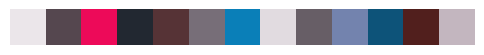

In [119]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,1))
plt.imshow([common_colors])
plt.axis('off')
plt.show()


In [120]:
labels = kmeans_all.fit_predict(brand_colors)

# Calculate fraction of each dominant color
color_percentages = []

for i in range(n_clusters):
    color_fraction = np.sum(labels == i) / len(labels)
    color_percentages.append(color_fraction * 100)

for color, perc in zip(common_colors, color_percentages):
    print(f"Colour {color} appears in {perc:.2f}% of the collection")


Colour [235 230 234] appears in 14.39% of the collection
Colour [85 71 79] appears in 10.61% of the collection
Colour [237  10  89] appears in 3.79% of the collection
Colour [34 40 49] appears in 5.30% of the collection
Colour [86 51 54] appears in 9.85% of the collection
Colour [119 110 120] appears in 9.85% of the collection
Colour [ 10 127 184] appears in 0.76% of the collection
Colour [225 219 224] appears in 18.94% of the collection
Colour [103  94 102] appears in 20.45% of the collection
Colour [115 131 174] appears in 0.76% of the collection
Colour [ 13  83 121] appears in 1.52% of the collection
Colour [81 31 29] appears in 3.03% of the collection
Colour [195 182 191] appears in 0.76% of the collection


SIHLOUETTE EXTRACTION - VGG16

In [30]:
# Optional: cluster all colors across images to find overall dominant colors
from sklearn.cluster import KMeans

kmeans_shape = KMeans(n_clusters=5, random_state=42)
#kmeans_shape.fit(silhouettes)
common_shapes = kmeans_shape.fit_predict(pca_results)

print("Most common silhouttes for brand:", common_shapes)


Most common silhouttes for brand: [2 2 1 1 1 3 3 1 1 4 0 0 2 2 2 3 2 2 1 1 1 3 3 1 1 4 0 0 2 2 2 3]


In [97]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,1))
plt.imshow([common_shapes])
plt.axis('off')
plt.show()

NameError: name 'common_shapes' is not defined

<Figure size 600x100 with 0 Axes>

DEEPLABV3 MODEL - COLOUR EXTRACTION (DONE), SIHLOUETTE EXTRACTION, FABRIC EXTRACTION

In [40]:
import torch
import torchvision
from torchvision import transforms
from PIL import Image
import numpy as np
from torchvision.transforms.functional import resize
import cv2
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from collections import Counter

In [41]:
preprocess = transforms.Compose([
    transforms.Resize((520,520)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

dataset_dict = {"kasbit_images": ["bellanaija"]}
preprocessed_images = {}

for kasbit, folders in dataset_dict.items():
    kasbit_img = []

    for folder in folders:
        folder_dir = os.path.join(kasbit, folder)
        
        for img_name in os.listdir(folder_dir):
            img_path = os.path.join(folder_dir, img_name)
           
            if not img_name.lower().endswith(('.jpg','.jpeg', '.png')):
                continue
            
            if "segmented" in img_path:
                continue

            try:
                input_image = Image.open(img_path).convert("RGB")
                input_tensor = preprocess(input_image)
                kasbit_img.append(input_tensor)
            
            except Exception as e:
                print(f"Error processing image {img_name}: {e}")
                continue

    preprocessed_images[kasbit] = torch.stack(kasbit_img)
    print(f"Segmented {len(kasbit_img)} images for {kasbit}.\n")

Segmented 44 images for kasbit_images.



In [ ]:
COLOURS = {
    # --- Warm Tones (The Maroons & Earth Tones) ---
    "Maroon": [40, 160, 140],        # The deep red lace dresses
    "Terracotta": [120, 160, 160],   # The orange-brown fringed skirts
    "Chocolate Brown": [50, 140, 150],# Dark brown structured pieces
    "Rust": [115, 155, 165],         # The burnt orange mid-tones
    "Mustard": [170, 140, 190],      # Golden/yellowish earth tones
    
    # --- The "Mauve" Group (The AI's favorite) ---
    "Mauve": [140, 150, 120],        # The dusty purple/grey fabric
    "Light Purple": [190, 145, 110], # Pale reflections on the Akwete
    
    # --- Cool Tones (The Teals & Blues) ---
    "Dark Teal": [70, 110, 120],     # The blue-green headwraps
    "Navy Blue": [40, 100, 110],     # Deep blue woven threads
    
    # --- Neutrals & Brights ---
    "Off-White": [240, 128, 132],    # The white shirts and base layers
    "Hot Pink": [150, 210, 130],     # The vibrant trousers
    "Cyan": [160, 80, 130],          # Bright blue accents
    "Charcoal": [60, 128, 128],      # Dark grey shadows/details
    "Light Gray": [192, 128, 128],   # Pale grey fabric highlights
    "Black": [30, 128, 128]          # Deepest black structural lines
}

def get_colour_name(lab_pixel):
    distances = {}
    for colour, lab_value in COLOURS.items():
        distance = np.linalg.norm(np.array(lab_pixel) - np.array(lab_value))
        distances[colour] = distance
    return min(distances, key=distances.get)

In [73]:
model2 = torchvision.models.segmentation.deeplabv3_mobilenet_v3_large(weights='DEFAULT')

model2.eval()

seg_outputs = {}
seg_masks = {}
garment_masks = {}
garment_img = {}
garment_lab = {}
garment_pixels_flat = {}
garment_colours = {}
garment_colour_names = {}

with torch.no_grad():
    for kasbit, images in preprocessed_images.items():
        outputs = model2(images)['out']
        seg_outputs[kasbit] = outputs
        print(f"Segmentation completed for {kasbit}.\n")

for kasbit, outputs in seg_outputs.items():
    masks = torch.argmax(outputs, dim=1)
    seg_masks[kasbit] = masks
    print(f"Masks extracted for {kasbit}.\n")

for kasbit, masks in seg_masks.items():
    garment_masks[kasbit] = masks != 0

for kasbit, masks in garment_masks.items():
    masked_img = []
    lab_img = []
    flattened_pixels = []
    colour_list = []
    named_colours = []

    for i, mask in enumerate(masks):
        img_path = os.path.join(kasbit, dataset_dict[kasbit][0], os.listdir(os.path.join(kasbit, dataset_dict[kasbit][0]))[i])

        img = Image.open(img_path).convert("RGB")
        img = resize(img, mask.shape[-2:])
        img_np = np.array(img)

        mask_np = mask.cpu().numpy()
        masked = img_np * mask_np[:, :, None]
        masked_img.append(masked)

        img_lab = cv2.cvtColor(masked.astype(np.uint8), cv2.COLOR_RGB2LAB)
        lab_img.append(img_lab)
        
        pixels_flat = img_lab[mask_np]
        flattened_pixels.append(pixels_flat)

        if len(pixels_flat) > 0:
            #samples = pixels_flat[::10]

            n = 5
            kmeans = KMeans(n_clusters=n, random_state=42)
            kmeans.fit(pixels_flat)
            
            names = [get_colour_name(centroid) for centroid in kmeans.cluster_centers_]
            unique_names = [n for n in set(names) if n != "Black" or len(set(names)) == 1]

            colour_list.append(kmeans.cluster_centers_)
            named_colours.append(list(set(names))) # unique names per garment
        else:
            colour_list.append(np.zeros((n, 3)))
            named_colours.append(['N/A'])

    garment_img[kasbit] = masked_img
    garment_lab[kasbit] = lab_img
    garment_pixels_flat[kasbit] = flattened_pixels
    garment_colours[kasbit] = colour_list
    garment_colour_names[kasbit] = named_colours

print("Garment images extracted and processed for all brands.")

Segmentation completed for kasbit_images.

Masks extracted for kasbit_images.

Garment images extracted and processed for all brands.


FREQUENCY OF COLOURS

In [74]:
colour_present = []
for kasbit, colour_names in garment_colour_names.items():
    for names in colour_names:
        colour_present.extend(names)

colour_count = Counter(colour_present)

sorted_colours = dict(sorted(colour_count.items(), key=lambda item: item[1], reverse=True))
names = list(sorted_colours.keys())
counts = list(sorted_colours.values())
total_colours = sum(counts)
percentages = [(count / total_colours) * 100 for count in counts]

VISUALIZATION

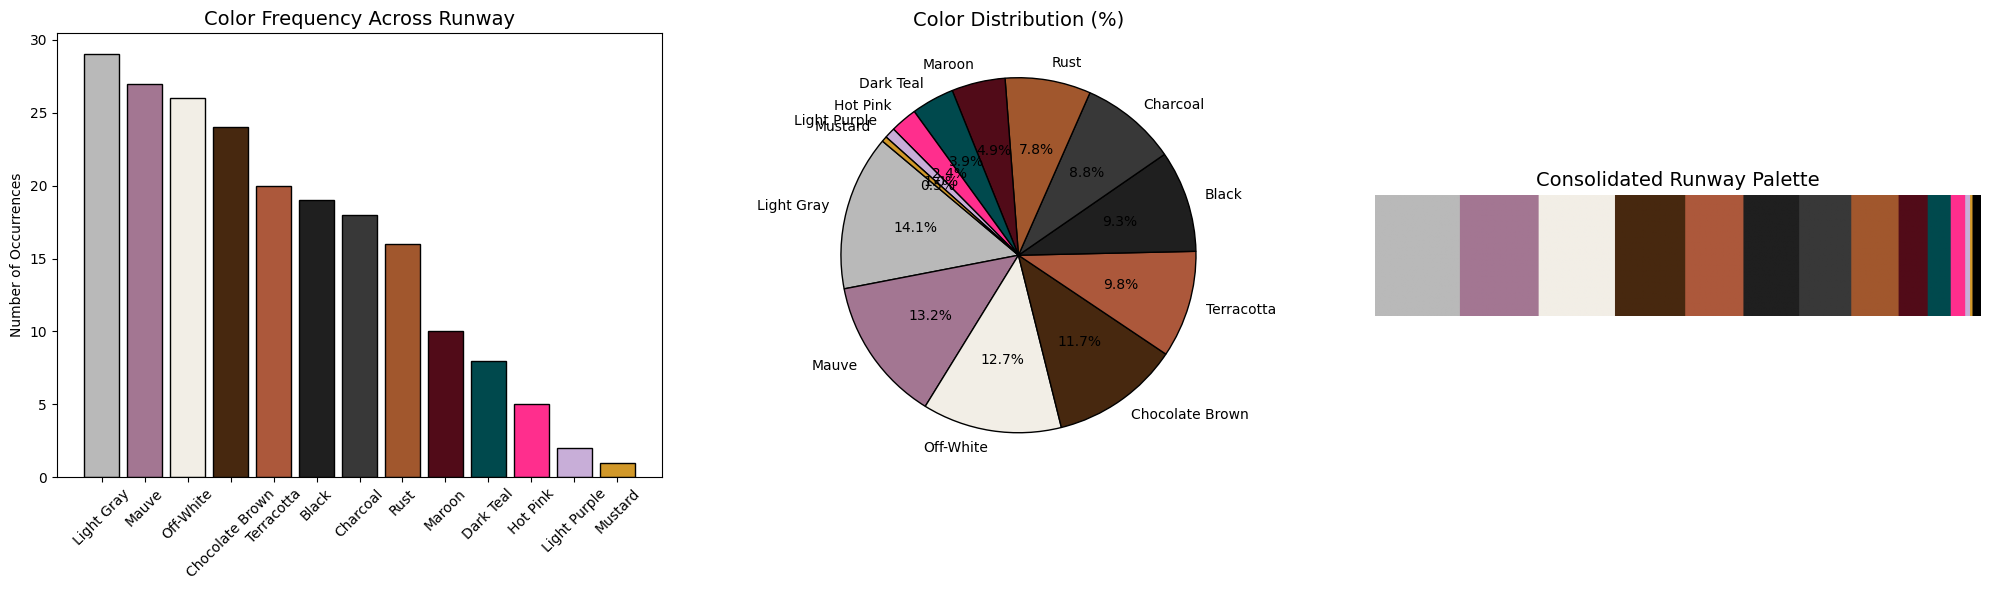

In [75]:
def name_to_lab(colour_name):
    lab_val = np.uint8([[COLOURS[colour_name]]])
    rgb_val = cv2.cvtColor(lab_val, cv2.COLOR_LAB2RGB)[0][0]
    return rgb_val / 255.0

plot_colours = [name_to_lab(colour) for colour in names]
for colour in names:
    lab = np.uint8([[COLOURS.get(colour, [0,0,0])]])
    rgb = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)[0][0]/255.0
    plot_colours.append(rgb)

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
# A. Bar Chart: Frequency
axes[0].bar(names, counts, color=plot_colours, edgecolor='black')
axes[0].set_title('Color Frequency Across Runway', fontsize=14)
axes[0].set_ylabel('Number of Occurrences')
axes[0].tick_params(axis='x', rotation=45)

# B. Percentage Chart: Distribution
axes[1].pie(percentages, labels=names, autopct='%1.1f%%', 
            colors=plot_colours, startangle=140, wedgeprops={'edgecolor': 'black'})
axes[1].set_title('Color Distribution (%)', fontsize=14)

# C. Color Palette: The "Runway Palette"
# We create a simple strip showing the dominant colors in order
palette_img = np.zeros((100, 500, 3))
start = 0
for i, perc in enumerate(percentages):
    end = start + int((perc / 100) * 500)
    palette_img[:, start:end] = plot_colours[i]
    start = end

axes[2].imshow(palette_img)
axes[2].axis('off')
axes[2].set_title('Consolidated Runway Palette', fontsize=14)

plt.tight_layout()
plt.show()

In [ ]:
# Show the result of DeepLabV3 for the first image
plt.imshow(garment_img[kasbit][0])
plt.title("DeepLabV3 Segmentation Result")
plt.show()